```
This notebook sets up an artificial case using the parameters from Staalstrøm et al.
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [7]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: a59db749692b363ce71ea29feb9a51d7969ad473 on branch reduced_gravity


# Oslofjord: Staalstrøm Parameters

In [8]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [9]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [10]:
%cuda_context_handler gpu_ctx

Path to the test file

In [11]:
source_url = "..\\..\\..\\..\\havvarsel-data\\test_polstere.nc"
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [12]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


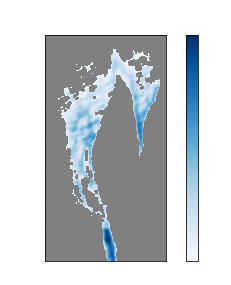

In [13]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap)

plt.colorbar(im, ax=ax)
plt.tight_layout()

Animation utils

In [14]:
import animation_utils

## Generating GPUOcean Simulation from Input

In [15]:
data_args = {}

In [16]:
dimY, dimX = ds.h.data.shape

In [17]:
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [18]:
import pyproj
proj_str = nc["projection"].proj4

proj = pyproj.Proj(proj_str)

lat_rho = nc.variables['lat_rho'][y0:y1, x0:x1]
lon_rho = nc.variables['lon_rho'][y0:y1, x0:x1]
x_rho, y_rho = proj(lon_rho, lat_rho, inverse = False)
x, y = x_rho[0], y_rho[:,0]

data_args['nx'] = (x1-x0)-4
data_args['ny'] = (y1-y0)-4

NX = data_args["nx"]+4
NY = data_args["ny"]+4

data_args['dx'] = np.average(x[1:] - x[:-1])
data_args['dy'] = np.average(y[1:] - y[:-1])

In [19]:
data_args["dx"], data_args["dy"]

(49.99992641175269, 50.000104021367484)

In [20]:
data_args['angle'] = nc["angle"][y0:y1, x0:x1]
from gpuocean.utils import OceanographicUtilities
data_args['latitude'] = OceanographicUtilities.degToRad(lat_rho)
data_args["f"] = 0.0

Check Mixed-Layer Depth

In [21]:
t=0#5*24 + 20 # INPUT

In [22]:
data_args["t"] = np.float32(nc["ocean_time"][t].data)
print("Simulation start time = " + str(datetime.datetime.utcfromtimestamp(data_args["t"]).strftime('%Y-%m-%d %H:%M:%S')))

Simulation start time = 2014-06-30 13:00:48


In [23]:
mld = NetCDFInitialization.MLD(source_url, 1024, min_mld=1.5, max_mld=40, x0=x0, x1=x1, y0=y0, y1=y1, t=t)
backup_mld = copy.deepcopy(mld)

In [24]:
# FIXME!!!
# mld = NetCDFInitialization.correct_coastal_MLD(mld, source_url, coords=[x0,x1,y0,y1], rel_tol=0.25, abs_tol=1, land_value=0.0)

mld = NetCDFInitialization.fill_coastal_data(mld)

#### Baroclinic model

In [25]:
H = 0.0

In [26]:
H_m_data = nc.variables['h'][y0-1:y1+1, x0-1:x1+1]
H_m_mask = (H_m_data == 0.0)
H_m = np.ma.array(H_m_data, mask=H_m_mask)
H_i = OceanographicUtilities.midpointsToIntersections(H_m, land_value=0.0, iterations=10)[0]

data_args["H"] = np.ma.array(H*np.ones_like(H_i), mask=H_i.mask.copy(), dtype=np.float32)

ML integrated data

In [27]:
ml_integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)

In [28]:
nc = Dataset(source_url)
u0 = nc.variables['u'][t, :, y0:y1, x0:x1+1]
v0 = nc.variables['v'][t, :, y0:y1+1, x0:x1]
#Find u,v at cell centers
u0 = u0.filled(fill_value = 0.0)
v0 = v0.filled(fill_value = 0.0)

u0 = (u0[:, :,1:] + u0[:, :, :-1]) * 0.5
v0 = (v0[:, 1:,:] + v0[:, :-1, :]) * 0.5

data_args["eta0"] = mld
data_args["hu0"] = np.sum(ml_integrator * u0, axis=0)
data_args["hv0"] = np.sum(ml_integrator * v0, axis=0)

In [29]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)
ml_pot_density = np.average(np.sum(ml_integrator * s_pot_densities, axis=0)/np.sum(ml_integrator, axis=0)) #NOTE: np.sum(integrator, axis=0)) = mld

inverse_integrator = np.ma.array(np.ones_like(ml_integrator), mask=ml_integrator.mask.copy()) - ml_integrator
deep_pot_density  = np.average(np.sum(inverse_integrator * s_pot_densities, axis=0)/np.sum(inverse_integrator, axis=0))

eps = (deep_pot_density - ml_pot_density)/deep_pot_density

data_args["g"] = eps * 9.81
data_args["g"]

0.02941468030093348

Artifical data

In [30]:
mld = np.ma.array( 15.0*np.ones_like(mld), mask=copy.copy(mld.mask) )

data_args["eta0"] = np.ma.array(mld.data - H, mask=copy.copy(mld.mask))

In [31]:
# init_mld_south = 2.5
# init_mld_north = 7.5

# mld.data[0:430] = init_mld_south*np.ones((430,mld.shape[1])) + (init_mld_north - init_mld_south)*np.ones((430,mld.shape[1]))*np.arange(0,1,1/430)[:,np.newaxis]
# mld.data[430:] = init_mld_north
# mld.data[:,235:] = init_mld_north
# mld = NetCDFInitialization.fill_coastal_data(mld)

# data_args["eta0"] = np.ma.array(mld.data - H, mask=copy.copy(mld.mask))

In [32]:
# Starting from lake at rest
data_args["hu0"] = np.ma.array(np.zeros_like(mld), mask=copy.copy(mld.mask))
data_args["hv0"] = np.ma.array(np.zeros_like(mld), mask=copy.copy(mld.mask))

In [33]:
data_args["g"] = 0.1

In [34]:
data_args["r"] = 1.0e-3#3.0e-3

Set-up osciallating BC

In [35]:
T = 5*24*3600  #Input

In [36]:
from gpuocean.utils import Common

In [37]:
data_args['boundary_conditions'] = Common.BoundaryConditions(north=3, south=3, east=3, west=3, spongeCells={'north':20, 'south': 20, 'east': 20, 'west': 20})

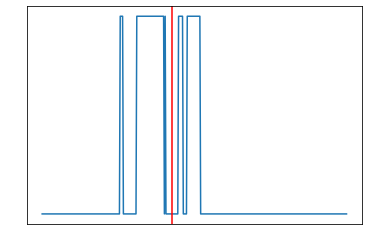

In [38]:
plt.plot(np.arange(0,mld.shape[1]),mld[0].filled(0.0))
plt.axvline(x=165, c="red")

In [39]:
t_step = 3600
T_steps = int(np.ceil(T/t_step)+1)

ts = data_args["t"] + np.arange(0, T+1, step=t_step)
ts_steps = ts-ts[0]

In [40]:
ampl_v = 0.3 #Input
freq = 12*3600 
bc_v_ref = ampl_v * np.sin(2*np.pi*ts_steps/freq)[:,np.newaxis] 

bc_v = np.zeros((T_steps, NX))
bc_v[:,165:] = np.ones((T_steps, NX-165)) * bc_v_ref

In [41]:
bc_h = mld[0].data*np.ones((T_steps,NX)) #np.tile(mld[0], (T_steps,1))

ampl_h = 4.0
bc_h[:,165:] = bc_h[:,165:] + ampl_h*np.ones_like(bc_h[:,165:])*np.sin(2*np.pi*ts_steps/freq)[:,np.newaxis]

bc_hv = bc_h*bc_v

bc_h = bc_h - H

Text(0, 0.5, '$zeta$ [m]')

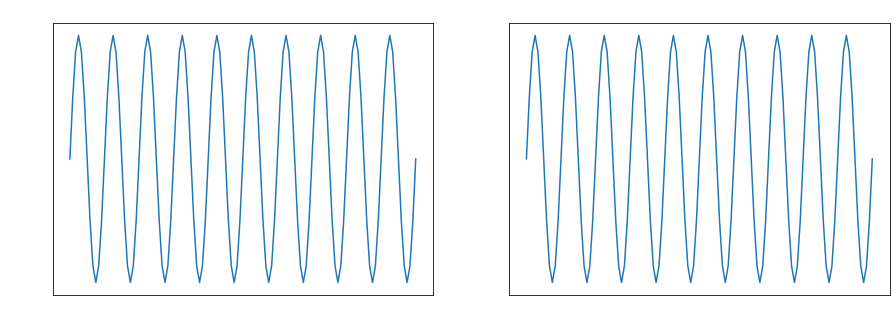

In [42]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].set_title("current forcing from the south boundary")
axs[0].plot((ts_steps/3600),bc_v[:,170])
axs[0].set_xlabel("time [h]")
axs[0].set_ylabel("u [m^2/s]")
axs[1].set_title("displacement forcing from the south boundary")
axs[1].plot((ts_steps/3600),bc_h[:,170])
axs[1].set_xlabel("time [h]")
axs[1].set_ylabel("$zeta$ [m]")

In [43]:
south = Common.SingleBoundaryConditionData(h=bc_h.astype(np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=bc_hv.astype(np.float32))
north = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NX), dtype=np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=np.zeros((T_steps, NX), dtype=np.float32))
east  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))
west  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))

data_args["boundary_conditions_data"] = Common.BoundaryConditionsData(ts, north=north, south=south, east=east, west=west)

Run simulation

In [44]:
from gpuocean.SWEsimulators import CDKLM16
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0,  **NetCDFInitialization.removeMetadata(data_args), write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [45]:
subt = 3600
for runt in range(int(T/subt)):#range(len(ds.ocean_time)):
    sim.step(subt)

if runt*subt > T:
    print("Boundary conditions too short!")

In [46]:
# with plt.rc_context({'lines.color':'black', 
#                         'text.color':'black', 
#                         'axes.labelcolor':'black', 
#                         'xtick.color':'black',
#                         'ytick.color':'black'}):
#     anim = animation_utils.ncAnimation(sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="GPUOcean")
#     anim.save("anims/GPUOceanSimulation-Staalstrom.mp4")

In [47]:
sim.g

0.1

### Reasonability comparison with Staalstrøm thesis

In [48]:
c = np.sqrt(sim.g*np.mean(mld)) # phase speed
print("Phase speed [m/s]: ", round(c, 3), "- NB! Staalstrøm et al. use a different formula, see Eq (1)")
f = 1.2e-4 # Coriolis 
L_R = c/f # Rossby radius
print("Rossby radius [km]: ", round(L_R/1000,3))

Phase speed [m/s]:  1.225 - NB! Staalstrøm et al. use a different formula, see Eq (1)
Rossby radius [km]:  10.206


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  del sys.path[0]


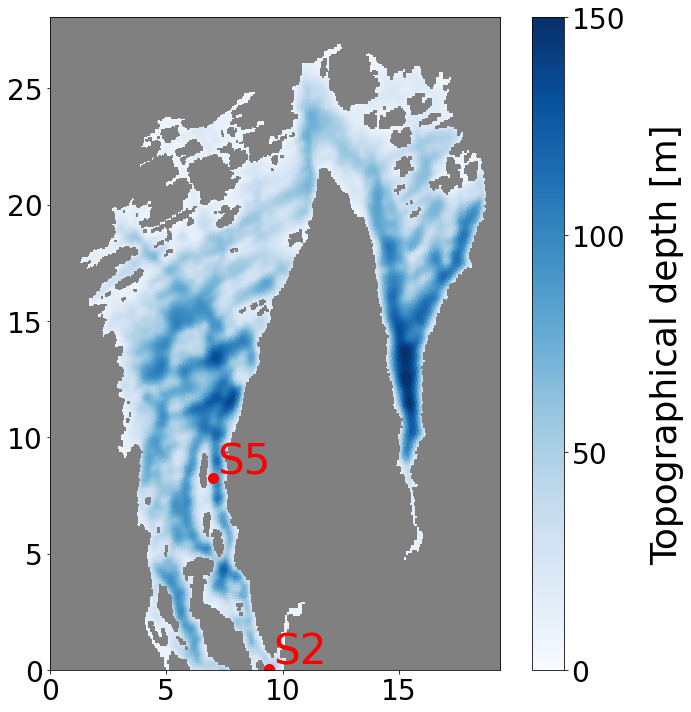

In [49]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    Hm = np.ma.array(nc["h"][y0:y1,x0:x1], mask=(1-nc["mask_rho"][y0:y1,x0:x1]))

    extent = [0, Hm.shape[1]*50/1000, 0, Hm.shape[0]*50/1000]

    fig, ax = plt.subplots(figsize=(10,10))

    cmap = plt.cm.Blues
    cmap.set_bad("grey", alpha = 1.0)
    im = ax.imshow(Hm, cmap=cmap, extent=extent, vmin=0, vmax=150)

    ax.tick_params(axis='both', which='major', labelsize=28)

    plt.scatter(188/Hm.shape[1]*Hm.shape[1]*50/1000 ,1/Hm.shape[0]*Hm.shape[0]*50/1000, c="red",s=100)
    plt.annotate("S2", (192/Hm.shape[1]*Hm.shape[1]*50/1000, 5/Hm.shape[0]*Hm.shape[0]*50/1000), c="red", fontsize=42)

    plt.scatter(140/Hm.shape[1]*Hm.shape[1]*50/1000, 165/Hm.shape[0]*Hm.shape[0]*50/1000, c="red", s=100)
    plt.annotate("S5", (144/Hm.shape[1]*Hm.shape[1]*50/1000, 169/Hm.shape[0]*Hm.shape[0]*50/1000), c="red", fontsize=42)

    cbar = plt.colorbar(im, ax=ax, ticks=[0, 50, 100, 150])
    cbar.set_label(label='Topographical depth [m]', size=36, labelpad=25)
    cbar.ax.tick_params(labelsize=28)
    plt.tight_layout()

    plt.savefig("figs/Oslofjord-bathymetry-stations.pdf", bbox_inches="tight")

In [50]:
gpuonc = Dataset(sim.sim_writer.output_file_name)

In [51]:
etaS2 = gpuonc["eta"][:,1,188]
uS2   = gpuonc["hu"][:,1,188]/gpuonc["eta"][:,1,188]
vS2   = gpuonc["hv"][:,1,188]/gpuonc["eta"][:,1,188]

etaS5 = gpuonc["eta"][:,165,140]
uS5   = gpuonc["hu"][:,165,140]/gpuonc["eta"][:,165,140]
vS5   = gpuonc["hv"][:,165,140]/gpuonc["eta"][:,165,140]

Text(0.5, 0, 'time [h]')

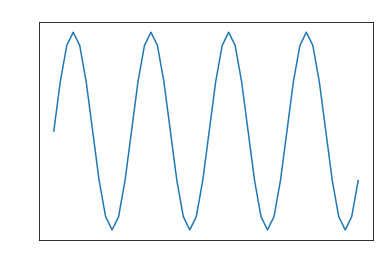

In [52]:
plt.title("Baroclinic upper layer speed")
plt.plot(vS2[:48])
plt.xlabel("time [h]")

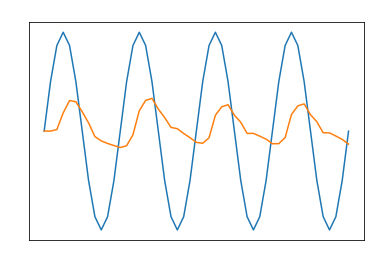

In [53]:
plt.title("Vertical displacement [m]")
plt.plot(etaS2[:49]-15, label="S2")
plt.plot(etaS5[:49]-15, label="S5")
plt.xlabel("time [h]")

np.savetxt("vertical_displacement.txt", np.vstack([etaS2-15, etaS5-15]).T, delimiter=",")

### Barotropic Partner Sim

In [54]:
bt_data_args = copy.deepcopy(data_args)

In [55]:
H_m_data = nc.variables['h'][y0-1:y1+1, x0-1:x1+1]
H_m_mask = (H_m_data == 0.0)
H_m = np.ma.array(H_m_data, mask=H_m_mask)
H_i = OceanographicUtilities.midpointsToIntersections(H_m, land_value=0.0, iterations=10)[0]

bt_data_args["H"] = np.ma.array(H_i, mask=H_i.mask.copy(), dtype=np.float32)

In [56]:
bt_data_args["g"] = 9.81

In [57]:
bt_data_args["eta0"] = np.ma.array(np.zeros_like(data_args["eta0"]), mask=copy.copy(data_args["eta0"].mask))

In [58]:
ampl_v = 0.1 #Input
freq = 12*3600 
bc_v_ref = ampl_v * np.sin(2*np.pi*ts_steps/freq)[:,np.newaxis] 

bc_v = np.zeros((T_steps, NX))
bc_v[:,165:] = np.ones((T_steps, NX-165)) * bc_v_ref

In [59]:
bc_h = H_m[1,1:-1].data*np.ones((T_steps,NX))

ampl_h = 0.15
bc_eta = np.zeros_like(bc_h)
bc_eta[:,165:] = ampl_h*np.ones_like(bc_h[:,165:])*np.sin(2*np.pi*ts_steps/freq)[:,np.newaxis]

bc_hv = bc_h*bc_v

In [60]:
south = Common.SingleBoundaryConditionData(h=bc_eta.astype(np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=bc_hv.astype(np.float32))
north = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NX), dtype=np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=np.zeros((T_steps, NX), dtype=np.float32))
east  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))
west  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))

bt_data_args["boundary_conditions_data"] = Common.BoundaryConditionsData(ts, north=north, south=south, east=east, west=west)

In [61]:
bt_sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0,  **NetCDFInitialization.removeMetadata(bt_data_args), write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [62]:
subt = 3600
for runt in range(48):#range(len(ds.ocean_time)):
    print(runt, " hours")
    bt_sim.step(subt)

if runt*subt > T:
    print("Boundary conditions too short!")

0  hours
1  hours
2  hours
3  hours
4  hours
5  hours
6  hours
7  hours
8  hours
9  hours
10  hours
11  hours
12  hours
13  hours
14  hours
15  hours
16  hours
17  hours
18  hours
19  hours
20  hours
21  hours
22  hours
23  hours
24  hours
25  hours
26  hours
27  hours
28  hours
29  hours
30  hours
31  hours
32  hours
33  hours
34  hours
35  hours
36  hours
37  hours
38  hours
39  hours
40  hours
41  hours
42  hours
43  hours
44  hours
45  hours
46  hours
47  hours


In [63]:
# with plt.rc_context({'lines.color':'black', 
#                         'text.color':'black', 
#                         'axes.labelcolor':'black', 
#                         'xtick.color':'black',
#                         'ytick.color':'black'}):
#     anim = animation_utils.ncAnimation(bt_sim.sim_writer.output_file_name, "gpuocean", comment="GPUOcean")
#     anim.save("anims/GPUOceanSimulation-Staalstrom-bt.mp4")

### Combined simulation

In [64]:
%cuda_context_handler bt_gpu_ctx

In [65]:
%cuda_context_handler bc_gpu_ctx

In [66]:
bt_sim = CDKLM16.CDKLM16(bt_gpu_ctx, dt=0.0,  **NetCDFInitialization.removeMetadata(bt_data_args), write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Oslofjord/netcdf_2023_03_23/CDKLM16_2023_03_23-08_54_40.nc ...


In [67]:
bc_sim = CDKLM16.CDKLM16(bc_gpu_ctx, dt=0.0,  **NetCDFInitialization.removeMetadata(data_args), write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [68]:
from gpuocean.SWEsimulators import CombinedCDKLM16

sims = CombinedCDKLM16.CombinedCDKLM16(barotropic_sim=bt_sim, baroclinic_sim=bc_sim)

In [69]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [70]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': sims.nx, 'ny': sims.ny,
                'domain_size_x': sims.nx*sims.dx,
                'domain_size_y': sims.ny*sims.dy,
                'land_mask': sims.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)
barotropic_trajectories = Observation.Observation(**observation_args)

In [71]:
initx = [ 6000, 8000, 5000, 12000, 15000,  4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

num_drifters = len(initx)

drifters = GPUDrifterCollection.GPUDrifterCollection(sims.barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream)

drifter_pos_init = np.array([initx, inity]).T
drifters.setDrifterPositions(drifter_pos_init)

In [72]:
barotropic_drifters = GPUDrifterCollection.GPUDrifterCollection(sims.barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream)
barotropic_drifters.setDrifterPositions(drifter_pos_init)

In [73]:
sims.attachDrifters(drifters, barotropic_drifters=barotropic_drifters)
trajectories.add_observation_from_sim(sims)
barotropic_trajectories.add_observation_from_sim(sims)

In [74]:
for hour in range(48):
    sims.combinedStep(3600.0, trajectory_dt=60, trajectories=trajectories, barotropic_trajectories=barotropic_trajectories)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
  from ipykernel import kernelapp as app


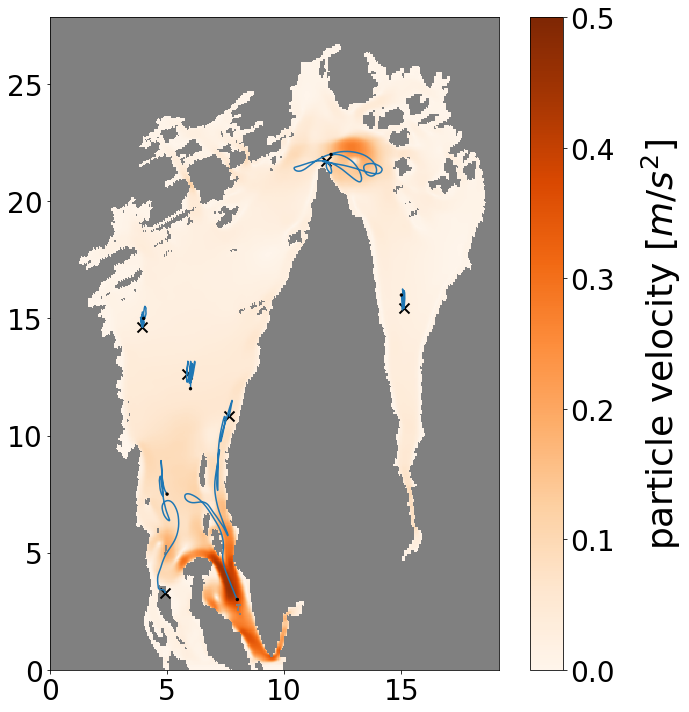

In [77]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=18)

    combined_eta, combined_u, combined_v = sims.download() 
    uv_field = np.sqrt(combined_u**2 + combined_v**2)

    domain_extent = [0, sims.nx*sims.dx/1000, 0, sims.ny*sims.dy/1000]

    velo_cmap = copy.deepcopy(plt.cm.Oranges)
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = ax.imshow(uv_field, interpolation="none", origin='lower', 
                    cmap=velo_cmap, 
                    vmin=0.0, vmax=0.5, 
                    extent=domain_extent)
    
    ax.tick_params(axis='both', which='major', labelsize=28)

    cb = plt.colorbar(im)
    cb.set_label(label="particle velocity [$m/s^2$]", size=36, labelpad=25)
    cb.ax.tick_params(labelsize=28)

    for d in range(len(initx)):
        drifter_path = trajectories.get_drifter_path(d, 0, sims.t, in_km = True)[0]
        
        start_pos = drifter_path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.05, color = 'black', fill=True, zorder=10)
        ax.add_patch(circ_start)

        ax.plot(drifter_path[:,0], drifter_path[:,1], color="C0", ls="-", zorder=5)

        end_pos = drifter_path[-1,:]
        ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2)

    plt.tight_layout()

    plt.savefig("figs/drift_combined.pdf", bbox_inches="tight")

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))


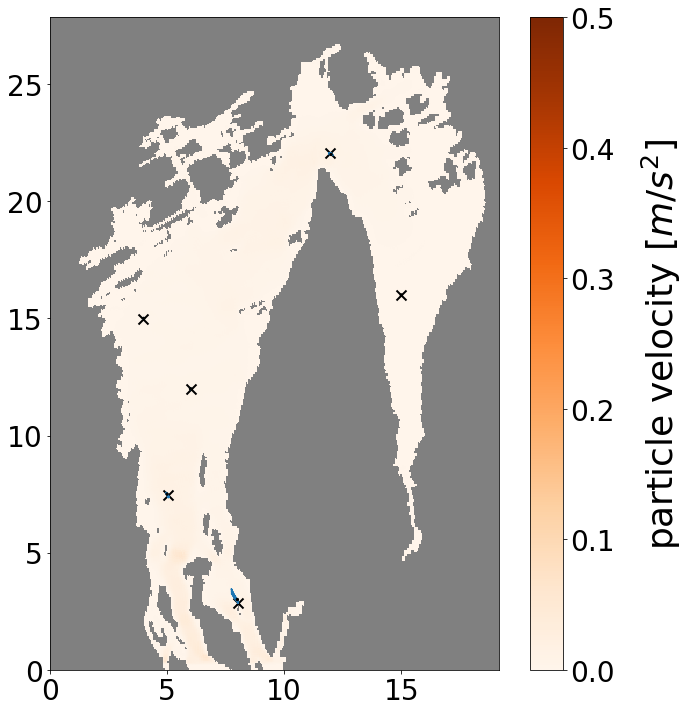

In [78]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=18)

    eta, hu, hv = sims.barotropic_sim.download() 
    h = np.ma.array( nc["h"][y0:y1,x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1])
    u = hu/h
    v = hv/h
    uv_field = np.sqrt(u**2 + v**2)

    domain_extent = [0, sims.nx*sims.dx/1000, 0, sims.ny*sims.dy/1000]

    velo_cmap = copy.deepcopy(plt.cm.Oranges)
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = ax.imshow(uv_field, interpolation="none", origin='lower', 
                    cmap=velo_cmap, 
                    vmin=0.0, vmax=0.5, 
                    extent=domain_extent)

    ax.tick_params(axis='both', which='major', labelsize=28)

    cb = plt.colorbar(im, ax=ax)
    cb.set_label(label="particle velocity [$m/s^2$]", size=36, labelpad=25)
    cb.ax.tick_params(labelsize=28)

    drifter_path = trajectories.get_drifter_path(0, 0, sims.t, in_km = True)[0]
    barotropic_drifter_path = barotropic_trajectories.get_drifter_path(0, 0, sims.t, in_km = True)[0]

    for d in range(len(initx)):
        barotropic_drifter_path = barotropic_trajectories.get_drifter_path(d, 0, sims.t, in_km = True)[0]
        
        start_pos = barotropic_drifter_path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.05, color = 'black', fill=True, zorder=10)
        ax.add_patch(circ_start)

        ax.plot(barotropic_drifter_path[:,0], barotropic_drifter_path[:,1], color="C0", ls="-", zorder=5)

        end_pos = barotropic_drifter_path[-1,:]
        ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2)

    # ax.legend(labelcolor="black")

    plt.tight_layout()

    plt.savefig("figs/drift_bt.pdf", bbox_inches="tight")